In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import itertools
from timeit import default_timer as timer
import scipy as sc
import pickle
import scipy.sparse as scs
from functools import lru_cache, cache
import random
import matplotlib as mpl

In [2]:
def boolean_combinations(n):
    return [
        *itertools.product(
            *[[False, True] for _ in range(n)]
    )]

In [3]:
states = boolean_combinations(10)

In [4]:
def el(state):
    e = 0
    e += (state[0]+state[3]+state[7]+3-state[2]-state[6]-state[9])*3+2

    for i in range(2):
        e += state[i] ^ state[i+1]
        e += state[i+7] ^ state[i+8]

    for i in range(3):
        e += state[i+3] ^state[i+4]
        e += state[i] ^ state[i+3]
        e += state[i] ^ state[i+4]

        e += state[i+7] ^ state[i+3]
        e += state[i+7] ^ state[i+4]
    return e

In [5]:
plaqs = np.zeros([2**10,10,3], dtype=int) # env, rot, subtype (true = subtype 2, false = subtype 1)

In [6]:
mat_e = np.array([el(state)*3/2 for state in states])

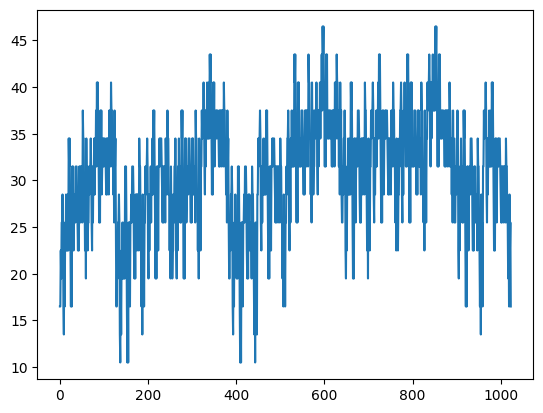

In [7]:
plt.plot(mat_e)

In [8]:
def reorder(idx, a):
    return a[-idx:] + a[:-idx]

In [9]:
def permcheck(plaq,reference):
    reference = [bool(i) for i in reference]
    reference2 = [not i for i in reference]
    for i in range(6):
        if plaq == reorder(i, reference) or plaq == reorder(i, reference2):
            return i
        
    return 7

In [10]:
def ident_plaq(plaq):
    outer = plaq[:6]

    if sum(outer)==0 or sum(outer)==6: # env 1
        return np.array([1,1,plaq[5] ^ plaq[6]])
        
    if sum(outer)==1 or sum(outer)==5: # env 2
        rot = permcheck(outer, [1,0,0,0,0,0])
        return np.array([2,rot,plaq[(5+rot)%6] ^ plaq[6]])
    
    if sum(outer)==2 or sum(outer)==4: # env 3, 5 and 7
        rot3 = permcheck(outer, [1,1,0,0,0,0])
        if rot3 != 7:
            return np.array([3,rot3,plaq[(5+rot3)%6] ^ plaq[6]])
        rot5 = permcheck(outer, [1,0,1,0,0,0])
        if rot5 != 7:
            return np.array([5,rot5,plaq[(5+rot5)%6] ^ plaq[6]])
        rot7 = permcheck(outer, [1,0,0,1,0,0])
        if rot7 != 7:
            return np.array([7,rot7,plaq[(5+rot7)%6] ^ plaq[6]])
        
    if sum(outer)==3: # env 4, 6 and 8
        rot4 = permcheck(outer, [1,1,1,0,0,0])
        if rot4 != 7:
            return np.array([4,rot4,plaq[(5+rot4)%6] ^ plaq[6]])
        rot6 = permcheck(outer, [1,0,1,1,0,0])
        if rot6 != 7:
            return np.array([6,rot6,plaq[(5+rot6)%6] ^ plaq[6]])
        rot8 = permcheck(outer, [1,0,1,0,1,0])
        if rot8 != 7:
            return np.array([8,rot8,plaq[(5+rot8)%6] ^ plaq[6]])
        
        



In [11]:
ext_vars = np.zeros(24, dtype=bool)
ext_vars[[2,3,8,14,19,22,23]] = True

for i in range(2**10):
    ext_vars[[5,6,7,10,11,12,13,16,17,18]] = states[i]

    for j in range(3):
        plaqs[i][j] = ident_plaq(list(ext_vars[[j+1,j+6,j+11,j+10,j+4,j,j+5]]))

        plaqs[i][j+7] = ident_plaq(list(ext_vars[[j+11,j+17,j+21,j+20,j+15,j+10,j+16]]))

    for j in range(4):
        plaqs[i][j+3] = ident_plaq(list(ext_vars[[j+5,j+11,j+16,j+15,j+9,j+4,j+10]]))

In [12]:
mat_m = np.zeros([2**10,2**10])

In [13]:
weights = [-128,32,32,32,-32,-32,-32,32]

In [14]:
for i in range(2**10):
    for j in range(2**10):
        if np.sum(states[i] + states[j])==1:
            for k in range(10):
                left = plaqs[i,k]
                right = plaqs[j,k]
                if left[0] == right[0] and left[1] == right[1] and left[2] != right[2]:
                    mat_m[i,j] += weights[right[0]-1]

In [15]:
np.linalg.eigvalsh(np.diag(mat_e)+mat_m)

array([-274.25589573,   10.5       ,   10.5       , ...,   46.5       ,
         46.5       ,  315.86768616], shape=(1024,))

In [16]:
n=50

g2s = np.linspace(0.5,10,n)

vals = np.empty([n,2**10])

In [17]:
for i in range(n):
    vals[i] = np.linalg.eigvalsh(g2s[i]*np.diag(mat_e)+mat_m*1/g2s[i])

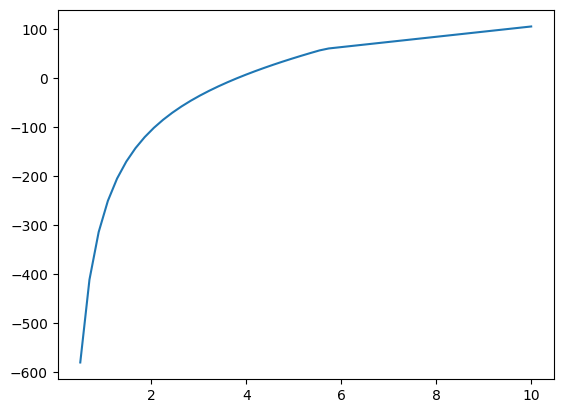

In [18]:
plt.plot(g2s, vals[:,0])

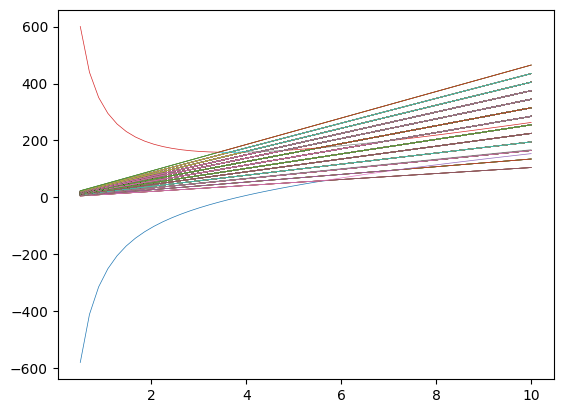

In [19]:
for i in range(2**10):
    plt.plot(g2s, vals[:,i], linewidth=0.5)

In [20]:
def vis_basis(state):
    links = np.empty(41,dtype=bool)

    ext_vars = np.zeros(24, dtype=bool)
    ext_vars[[2,3,8,14,19,22,23]] = True
    ext_vars[[5,6,7,10,11,12,13,16,17,18]] = state

    for i in range(3):
        links[i*2] = ext_vars[i] ^ext_vars[i+5]
        links[i*2+1] = ext_vars[i+5] ^ext_vars[i+1]
        links[i*2+35] = ext_vars[i+16] ^ext_vars[i+20]
        links[i*2+36] = ext_vars[i+16] ^ext_vars[i+21]

    for i in range(4):
        links[i+6] = ext_vars[i+4] ^ext_vars[i+5]
        links[i*2+10] = ext_vars[i+4] ^ext_vars[i+10]
        links[i*2+11] = ext_vars[i+5] ^ext_vars[i+10]
        links[i*2+23] = ext_vars[i+10] ^ext_vars[i+15]
        links[i*2+24] = ext_vars[i+10] ^ext_vars[i+16]
        links[i+31] = ext_vars[i+15] ^ext_vars[i+16]

    for i in range(5):
        links[i+18] = ext_vars[i+9] ^ext_vars[i+10]

    return links

In [21]:
def plotter(link_weights):
    cmap = mpl.colormaps["coolwarm"]
    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    colors = cmap(norm(link_weights))
    fig, ax = plt.subplots()

    starts = np.zeros([41,2])
    ends = np.zeros([41,2])

    h = np.sqrt(3)
    
    for i in range(3):
        starts[i*2] = [-1.5*h+i*h,2]
        starts[i*2+1] = [-1*h+i*h,2.5]
        starts[i*2+35] = [-1.5*h+i*h,-2]
        starts[i*2+36] = [-1*h+i*h,-2.5]
    
        ends[i*2] = [-1*h+i*h,2.5]
        ends[i*2+1] = [-0.5*h+i*h,2]
        ends[i*2+35] = [-1*h+i*h,-2.5]
        ends[i*2+36] = [-0.5*h+i*h,-2]

    for i in range(4):
        starts[i+6] = [-1.5*h+i*h,1]
        starts[i*2+10] = [-2*h+i*h,0.5]
        starts[i*2+11] = [-1*h+i*h,0.5]
        starts[i*2+23] = [-2*h+i*h,-0.5]
        starts[i*2+24] = [-1*h+i*h,-0.5]
        starts[i+31] = [-1.5*h+i*h,-1]
    
        ends[i+6] = [-1.5*h+i*h,2]
        ends[i*2+10] = [-1.5*h+i*h,1]
        ends[i*2+11] = [-1.5*h+i*h,1]
        ends[i*2+23] = [-1.5*h+i*h,-1]
        ends[i*2+24] = [-1.5*h+i*h,-1]
        ends[i+31] = [-1.5*h+i*h,-2]

    for i in range(5):
        starts[i+18] = [-2*h+i*h,0.5]
        ends[i+18] = [-2*h+i*h,-0.5]
    
    for i in range(41):
        ax.plot([starts[i,0], ends[i,0]],[starts[i,1],ends[i,1]], color=colors[i], linewidth=3)

    plt.show()

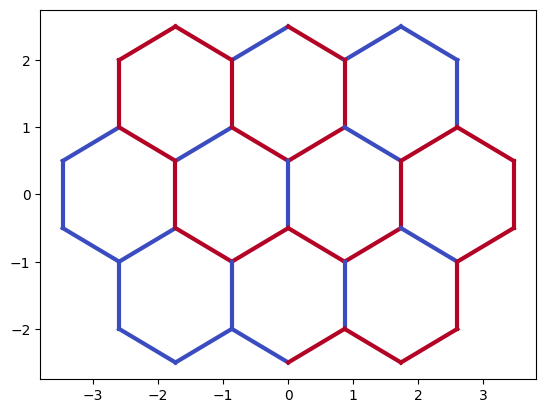

In [22]:
plotter(vis_basis(states[688]))

In [59]:
g = 1
vals, vecs = np.linalg.eigh(np.diag(mat_e)*g+mat_m*0/g)

In [60]:
sortinds = vals.argsort()
sorted_vals = vals[sortinds]
sorted_vecs = vecs[sortinds]

In [68]:
sorted_vals[1]

np.float64(10.5)

In [62]:
np.sum(vecs[0]**2)

np.float64(1.0)

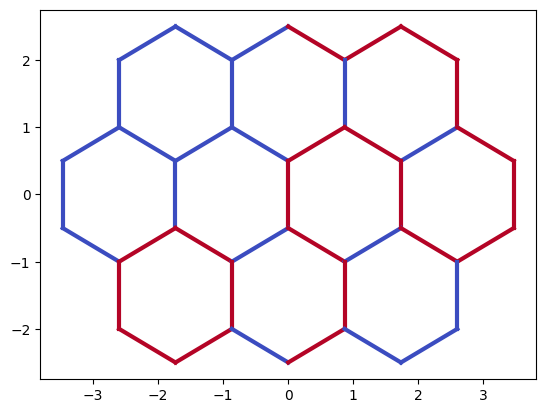

In [69]:
state1 = np.zeros(41)
for i in range(2**10):
    state1 += vis_basis(states[i])*sorted_vecs[1,i]**2

plotter(state1)

In [64]:
np.diag(mat_m).max()

np.float64(0.0)

In [65]:
sorted_vecs[0].argmax()

np.int64(18)

In [66]:
states[141]

(False, False, True, False, False, False, True, True, False, True)